<img src="https://drive.google.com/uc?export=view&id=1JIIlkTWa2xbft5bTpzhGK1BxYL83bJNU" width="800"/>

In [ ]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

# 🔥 Video Search Demo
---

In this demo, we’ll use NOS to build an end-to-end semantic video search application. Let's first start the nos server.

In [2]:
import nos

nos.init(runtime="auto")

2023-10-17 14:24:07.551 | INFO     | nos.server:_pull_image:227 - Found up-to-date server image: autonomi/nos:0.1.0a0-gpu
2023-10-17 14:24:07.552 | INFO     | nos.server:init:161 - Starting inference service: [name=nos-inference-service-gpu, runtime=InferenceServiceRuntime(image=autonomi/nos:0.1.0a0-gpu, name=nos-inference-service-gpu, device=gpu)]
2023-10-17 14:24:07.569 | WARNING  | nos.server._docker:start:104 - Container with same name already exists, removing it (name=nos-inference-service-gpu).
2023-10-17 14:24:07.963 | INFO     | nos.server:init:188 - Inference service started: [name=nos-inference-service-gpu, runtime=InferenceServiceRuntime(image=autonomi/nos:0.1.0a0-gpu, name=nos-inference-service-gpu, device=gpu), image=<Image: 'autonomi/nos:0.1.0a0-gpu', 'autonomi/nos:latest-gpu'>, id=6a773da7a421]


<Container: 6a773da7a421>

#### Frame Inference

Let's embed the video frame by frame with NOS. We'll start by connecting a client to the NOS server:

In [3]:
from nos.common.io.video.opencv import VideoReader
from nos.client import Client, TaskType

client = Client()
client.WaitForServer()
client.IsHealthy()

True

Now lets use the client to embed the video frame by frame into a stack of feature vectors. This should take a couple of minutes:

In [14]:
import requests
from nos.common.io.video.opencv import VideoReader
from nos.constants import NOS_CACHE_DIR

# Download the remote video
URL = "https://zackakil.github.io/video-intelligence-api-visualiser/assets/test_video.mp4"
FILENAME = NOS_CACHE_DIR / "test_data/test_video.mp4"
if not FILENAME.exists():
    FILENAME.parent.mkdir(parents=True, exist_ok=True)
    with open(str(FILENAME), "wb") as f:
        f.write(requests.get(URL).content)

# Load the video
video = VideoReader(str(FILENAME))
print(video)

VideoReader(filename=/home/spillai/.nos/cache/test_data/test_video.mp4, frames=6059, duration=0:03:21]


In [7]:
import numpy as np
from PIL import Image

from nos.common import tqdm
from nos.test.utils import get_benchmark_video

# Initialize the openai/clip model as a module
clip = client.Module("openai/clip", shm=True)

# Extract features from the video on a frame-level basis
# Note: we resize the image to 224x224 before encoding
features = [
    clip.encode_image(images=Image.fromarray(img).resize((224, 224)))["embedding"] 
    for img in tqdm(video)
]

# Stack and normalize the features so that they are unit vectors
video_features = np.vstack(features)
video_features /= np.linalg.norm(video_features, axis=1, keepdims=True)

video=VideoReader(filename=/home/spillai/.nos/cache/test_data/videos/test_video.mp4, frames=6059, duration=0:03:21]


  0%|          | 0/6059 [00:00<?, ?it/s]

100%|██████████| 6059/6059 [03:53<00:00, 25.91it/s]


Let's define our search function. we'll embed the text query (using the NOS openai/clip endpoint) and take the dot product with the video features to generate per-frame similarity scores before returning the top result.

In [27]:
def search_video(query: str, video_features: np.ndarray, topk: int = 3):
    """Semantic video search demo in 8 lines of code"""
    # Encode text and normalize
    text_features = clip.encode_text(texts=query)["embedding"].copy()
    text_features /= np.linalg.norm(text_features, axis=1, keepdims=True)

    # Compute the similarity between the search query and each video frame
    similarities = (video_features @ text_features.T)
    best_photo_idx = similarities.flatten().argsort()[-topk:][::-1]
    
    # Display the top k frames
    results = np.hstack([video[int(frame_id)] for frame_id in best_photo_idx])
    filepath = '_'.join(query.split(' ')) + '.png'
    display(Image.fromarray(results).resize((600, 400)))

Now let's try out a few queries:

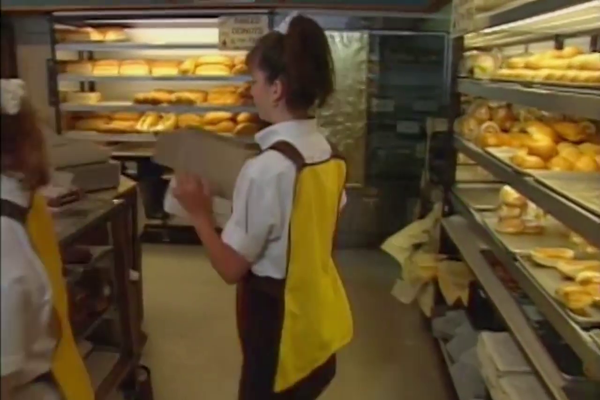

In [26]:
search_video("bakery with bread on the shelves", video_features, topk=1)

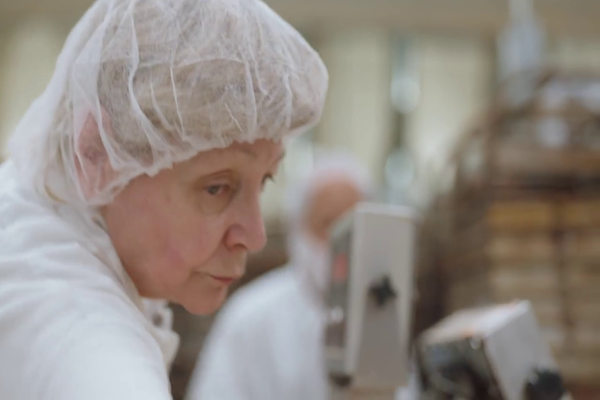

In [32]:
search_video("old woman with hat", video_features, topk=1)

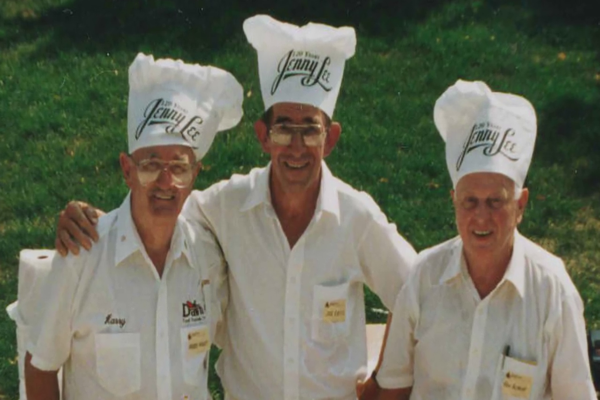

In [33]:
search_video("three men together", video_features, topk=1)

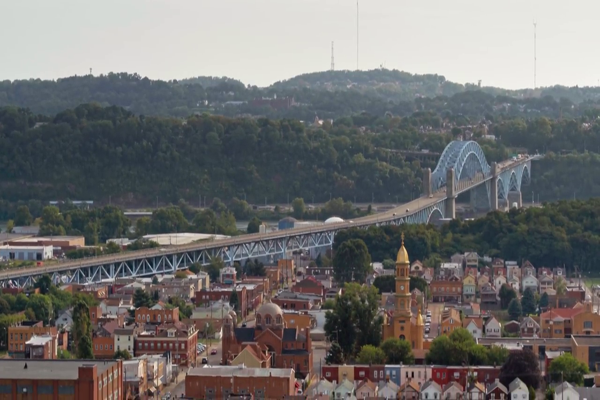

In [29]:
search_video("bridge over river", video_features, topk=1)